<a href="https://colab.research.google.com/github/SeamusWhoriskey/ELEC301PROJ1/blob/master/Project1_Hadamard_and_Haar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import scipy.io as sc
from scipy import signal
import numpy as np
import math
import matplotlib
import matplotlib.image as im
import matplotlib.pyplot as plt
import time
import struct
import scipy

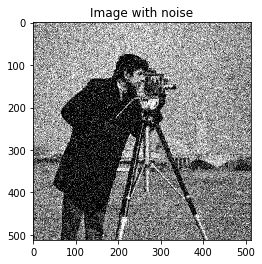

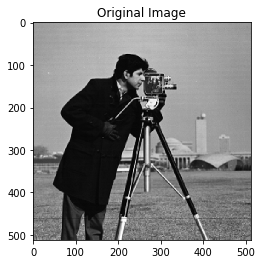

original mse: 0.022020593 

(4.995327666946187, 'fixed, universal')
actual variance: 0.025
threshold 4: 0.7898306543202479


In [6]:
image = im.imread('/content/drive/My Drive/FALL 2020/Signals/Colab Notebooks/cameraman_025.png')
plt.imshow(image, interpolation='nearest', cmap='gray')
plt.title('Image with noise')
plt.show()
N,M = image.shape 
og_image = im.imread('/content/drive/My Drive/FALL 2020/Signals/Colab Notebooks/cameraman_original.png')
plt.imshow(og_image, interpolation='nearest', cmap='gray')
plt.title('Original Image')
plt.show()



mse = (np.square(image - og_image)).mean(axis=None)
print('original mse:',mse,'\n')

threshold1 = (math.sqrt(2*np.log(N*M)),'fixed, universal')
print(threshold1)


#using actual variance:
noise = 0.025
threshold4 = (math.sqrt(2*noise*np.log(N*M)),'actual variance')



print("actual variance:",noise)
print("threshold 4:",threshold4[0])





In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


estimated median variance: 0.025266654487740303
estimated mean variance: 0.030062886565052294
threshold: 0.794031719475325 median
mse: 0.007643452853448531


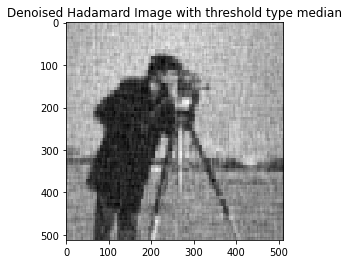

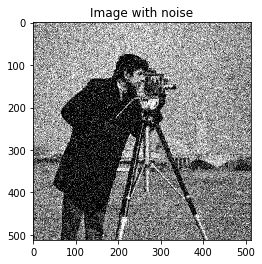

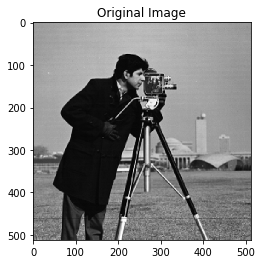

In [7]:
#HADAMARD TRANSFORM


#image = np.array([[1,7],[3,3]]) #test matrix
# print(image)

#N = 2 #test dimension

def makeHd(N):
  Hd = np.zeros((N,N))

  scalar = 2 ** (-math.log(N,2)/2) #to make it orthonormal (magnitude of each basis vector is 1)

  #fill in Hadamard with (scaled) 1's or -1's
  for i in range(0,len(Hd)):
    for j in range(0,len(Hd)):
      if (bin(i&j).count("1")%2==0): #sum of bitwise and between i and j
        Hd[i,j] = scalar #1*magnitude (because even exponent)
      else:
        Hd[i,j] = -scalar #-1*magnitude (because odd exponent)
  
  return Hd

HdN = makeHd(N)
HdM = makeHd(M)


#Matrix multiplication to change the basis to Hadamard

had_trans_image = np.matmul(np.matmul(HdN, image),HdM)

# print(had_trans_image)

#thresholding each element in matrix of Hadamard basis

#MAD (median) threshold

image_median_value = np.median(had_trans_image)
deviation = had_trans_image - image_median_value
abs_deviation = np.absolute(deviation)
abs_deviation_median_value = np.median(abs_deviation)
dev = abs_deviation_median_value/0.6745 

print("estimated median variance:",dev ** 2)
threshold2 = (math.sqrt(2*(dev ** 2)*np.log(N*M)),'median')

#MAD (mean) threshold

image_mean_value = np.mean(had_trans_image)
deviation_mean = had_trans_image - image_mean_value
abs_deviation_mean = np.absolute(deviation_mean)
abs_deviation_mean_value = np.mean(abs_deviation_mean)
dev_mean = abs_deviation_mean_value/0.7981

print("estimated mean variance:",dev_mean ** 2)
threshold3 = (math.sqrt(2*(dev_mean ** 2)*np.log(N*M)),'mean')



(t,r) = threshold2 #threshold value

thresholded_had = np.matrix.copy(had_trans_image)

#hard thresholding:

thresholded_had[abs(thresholded_had)<t] = 0.0

#soft thresholding: (uncomment the following two lines)

# thresholded_had[np.sign(thresholded_had)>0] = thresholded_had[np.sign(thresholded_had)>0] - t
# thresholded_had[np.sign(thresholded_had)<0] = thresholded_had[np.sign(thresholded_had)<0] + t

#inverse Hadamard which is same forward and backward because it is unitary (transpose is itself)

denoised_had_image = np.matmul(np.matmul(HdN, thresholded_had),HdM)

mse = (np.square(denoised_had_image - og_image)).mean(axis=None)
print('threshold:',t,r)
print('mse:',mse)
      
plt.imshow(denoised_had_image, interpolation='nearest', cmap='gray')
plt.title('Denoised Hadamard Image with threshold type {}'.format(r))
plt.show()

plt.imshow(image, interpolation='nearest', cmap='gray')
plt.title('Image with noise')
plt.show()

plt.imshow(og_image, interpolation='nearest', cmap='gray')
plt.title('Original Image')
plt.show()

estimated median variance: 0.025563553122629798
estimated mean variance: 0.10398213814186101
threshold: 1.6108064228014878 mean
mse: 0.013778165164460135


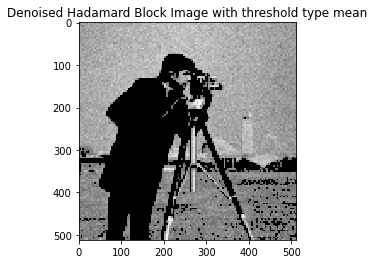

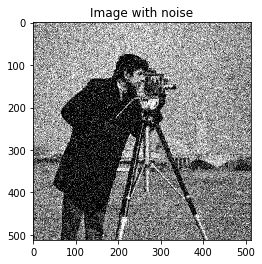

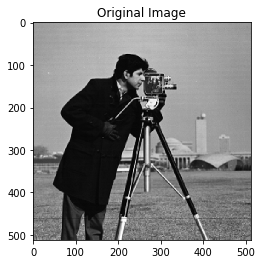

In [8]:
#HADAMARD BLOCK TRANSFORM

p = 4 #block size

def makeHdB(N):
  HdB = np.zeros((N,N))

  scalar = 2 ** (-math.log(N,2)/2) #to make it orthonormal (magnitude of each basis vector is 1)

  #fill in Hadamard with (scaled) 1's or -1's
  for i in range(0,len(HdB)):
    for j in range(0,len(HdB)):
      if (bin(i&j).count("1")%2==0): #sum of bitwise and between i and j
        HdB[i,j] = scalar #1*magnitude (even exponent)
      else:
        HdB[i,j] = -scalar #-1*magnitude (odd exponent)

  return HdB

HdBp = makeHdB(p)

had_trans_BLOCK_image = np.zeros(image.shape)

#Matrix multiplication on each block to change the basis to Hadamard

for i in range(0,image.shape[0]-p+1,p): #for each row in image, skipping by ps
    for j in range(0, image.shape[1]-p+1,p): #for each column in image, skipping by ps
        had_trans_BLOCK_image[i:i+p,j:j+p] = np.matmul(np.matmul(HdBp,image[i:i+p,j:j+p]),HdBp) 
        



#thresholding each element in matrix block of Hadamard basis

image_median_value = np.median(had_trans_BLOCK_image)
deviation = had_trans_BLOCK_image - image_median_value
abs_deviation = np.absolute(deviation)
abs_deviation_median_value = np.median(abs_deviation)
dev = abs_deviation_median_value/0.6745 

print("estimated median variance:",dev ** 2)
threshold2 = (math.sqrt(2*(dev ** 2)*np.log(N*M)),'median')



image_mean_value = np.mean(had_trans_BLOCK_image)
deviation_mean = had_trans_BLOCK_image - image_mean_value
abs_deviation_mean = np.absolute(deviation_mean)
abs_deviation_mean_value = np.mean(abs_deviation_mean)
dev_mean = abs_deviation_mean_value/0.7981

print("estimated mean variance:",dev_mean ** 2)
threshold3 = (math.sqrt(2*(dev_mean ** 2)*np.log(N*M)),'mean')


(tb,rb) = threshold3 #threshold value



thresholded_had_BLOCK = np.matrix.copy(had_trans_BLOCK_image)

#hard thresholding:

thresholded_had_BLOCK[abs(thresholded_had_BLOCK)<tb] = 0

#soft thresholding: (uncomment the following two lines)

# thresholded_had_BLOCK[np.sign(thresholded_had_BLOCK)>0] = thresholded_had_BLOCK[np.sign(thresholded_had_BLOCK)>0] - tb
# thresholded_had_BLOCK[np.sign(thresholded_had_BLOCK)<0] = thresholded_had_BLOCK[np.sign(thresholded_had_BLOCK)<0] + tb


denoised_had_BLOCK_image = np.zeros(image.shape)

#inverse Hadamard for each block

for i in range(0,image.shape[0]-p+1,p): #for each row in image, skipping by Ns
    for j in range(0, image.shape[1]-p+1,p): #for each column in image, skipping by Ns
        denoised_had_BLOCK_image[i:i+p,j:j+p] = np.matmul(np.matmul(HdBp,thresholded_had_BLOCK[i:i+p,j:j+p]),HdBp) 

mse = (np.square(denoised_had_BLOCK_image - og_image)).mean(axis=None)
print('threshold:',tb,rb)
print('mse:',mse)

plt.imshow(denoised_had_BLOCK_image, interpolation='nearest', cmap='gray')
plt.title('Denoised Hadamard Block Image with threshold type {}'.format(rb))
plt.show()

plt.imshow(image, interpolation='nearest', cmap='gray')
plt.title('Image with noise')
plt.show()

plt.imshow(og_image, interpolation='nearest', cmap='gray')
plt.title('Original Image')
plt.show()


estimated median variance: 0.022413529534311197
estimated mean variance: 0.027467048501136675
threshold: 0.7478579363166346 median
mse: 0.0036576627440305814


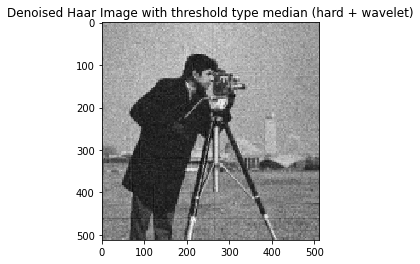

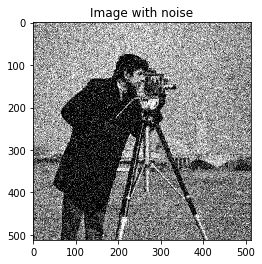

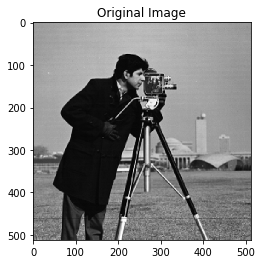

In [63]:
#HAAR TRANSFORM

def makeHr(N):

  Hr = np.zeros((N,N)) #haar matrix to fill in

  #first row is all ones
  for p in range(N):
    Hr[0,p] = 1/(math.sqrt(N)) #normalized top row

  j = 1 #j is the max row number with the same pattern just shifted so for 8 point haar 
        #j = 1 for 1111 -1-1-1-1 (since theres only one row of that) and 
        #j = 2 for 11 -1-1 (since next two rows are that pattern)
        #j = 4 for the 1 -1 (since the last 4 rows are that pattern) 

  count = 0 #need to raise 2 to the power of count to get next j for next pattern 1,2,4,8....(see above)

  row = 1 #start at second row

  #when normalixing i know each scaling depends on what my length is of the pattern so whatever it is 
  #the magnitude is square root of that because they are all ones squared like sqrt(1^2 + (-1)^2 + ... length times)

  while (j < N): #j should be less than N 
    length = N/(2**count) #length of 11..-1-1.. for each row, it is current j (row max) minus previous j (last row) divided from N
    scale = 1/(math.sqrt(length)) #normalized, divide by magnitude of each pattern (same for each j) (see above)
    i = 0 #column number, set to 0 every time new j for new pattern is created
    while (row <= j):   #go through row max
      for k in range(int(length/2)): #only need to go halfway length filling columns i with ones (scaled) because...
        Hr[row,i] = 1*scale
        Hr[row,int(i+length/2)] = -1*scale #...-1 (scaled) is always the other half, a unit of half total length apart
        i+=1 #next column
      i+=int(length/2) #when going to next row, we only made i go through half the length but the col indices we covered
                      #went to the full length, so add that when moving on
      row+=1  #next row
    count+=1  #next pattern
    j += (2 ** count) #increase j up til the height the next pattern is covered

  return Hr

HrN = makeHr(N)
HrM = makeHr(M)

# check if orthonormal
# isidentity = np.matmul(Hr, np.transpose(Hr))
# print(isidentity)

#Matrix multiplication to change the basis to Haar

hr_trans_image = np.matmul(np.matmul(HrN, image),np.transpose(HrM))


#thresholding each element in matrix of Haar basis

image_median_value = np.median(hr_trans_image)
deviation = hr_trans_image - image_median_value
abs_deviation = np.absolute(deviation)
abs_deviation_median_value = np.median(abs_deviation)
dev = abs_deviation_median_value/0.6745 

print("estimated median variance:",dev ** 2)
threshold2 = (math.sqrt(2*(dev ** 2)*np.log(N*M)),'median')



image_mean_value = np.mean(hr_trans_image)
deviation_mean = hr_trans_image - image_mean_value
abs_deviation_mean = np.absolute(deviation_mean)
abs_deviation_mean_value = np.mean(abs_deviation_mean)
dev_mean = abs_deviation_mean_value/0.7981

print("estimated mean variance:",dev_mean ** 2)
threshold3 = (math.sqrt(2*(dev_mean ** 2)*np.log(N*M)),'mean')

(tr,rr) = threshold2 #threshold value


thresholded_hr = np.matrix.copy(hr_trans_image)

#hard thresholding: (uncomment the following 1 line)

#thresholded_hr[abs(thresholded_hr)<tr] = 0.0

#hard(ish) thresholding

thresholded_hr[abs(thresholded_hr)<tr] = 0.1*np.exp(thresholded_hr[abs(thresholded_hr)<tr])*thresholded_hr[abs(thresholded_hr)<tr]


#wavelet based thresholding (leave lower order wavelets, top rows, unaffected):

#fraction of top remaining unchanged (1/s)
s = 4
thresholded_hr[0:int(N/s), 0:int(M/s)] = hr_trans_image[0:int(N/s), 0:int(M/s)]

#trying something new:

for row in range(N):
  for col in range(M):
    thresholded_hr[row,col] = math.exp(-row/N*col/M)*thresholded_hr[row,col]

#soft thresholding: (uncomment the following two lines)

# thresholded_hr[np.sign(thresholded_hr)>0] = thresholded_hr[np.sign(thresholded_hr)>0] - tr
# thresholded_hr[np.sign(thresholded_hr)<0] = thresholded_hr[np.sign(thresholded_hr)<0] + tr

#inverse Haar which is the Haar transpose matrix

denoised_hr_image = np.matmul(np.matmul(np.transpose(HrN), thresholded_hr),HrM)

mse = (np.square(denoised_hr_image - og_image)).mean(axis=None)
print('threshold:',tr,rr)
print('mse:',mse)

plt.imshow(denoised_hr_image, interpolation='nearest', cmap='gray')
plt.title('Denoised Haar Image with threshold type {} (hard + wavelet)'.format(rr))
plt.show()

plt.imshow(image, interpolation='nearest', cmap='gray')
plt.title('Image with noise')
plt.show()

plt.imshow(og_image, interpolation='nearest', cmap='gray')
plt.title('Original Image')
plt.show()
